In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.fft import fft, ifft, fftfreq
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
from pandas.tseries.offsets import MonthBegin
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Hard-Coded Variables 
- uses domain knowledge 

In [ ]:
#hardcoded information
expected_groups = {
    ('A', 7),
    ('A', 8),
    ('B', 1),
    ('B', 2),
    ('C', 3),
    ('C', 4),
    ('D', 5),
    ('D', 6),
}

group_1 = {1,2,7,8}
group_2 = {3,4,5,6}
group_1_feature_bounds = {
    "wheeldiameter": (29.0, 41),
    "wheelwidth": (5.50, 5.9),
    "flangeheight": (0.90, 1.55),
    "flangethickness": (0.85, 1.75),
    "flangeslope": (0.10, 0.60),
    "treadhollow": (0.01, 5.3),
    "rimthickness": (0.75, 1.85),
    "backtobackgauge": (52.0, 53.0),
}
group_2_feature_bounds = {
    "wheeldiameter": (29.0, 46.0),
    "wheelwidth": (5.50, 5.87),
    "flangeheight": (0.90, 1.55),
    "flangethickness": (0.85, 1.75),
    "flangeslope": (0.10, 0.60),
    "treadhollow": (0.01, 5.1),
    "rimthickness": (0.80, 2.1),
    "backtobackgauge": (52.0, 53.0),
}

group_2_severity_thresholds = {'backtobackgauge': [(52.0, -5), (52.0, -4), (52.0, -3), (52.0, -2), (52.0, -1),
                     (53.0, 1), (53.0, 2), (53.0, 3), (53.0, 4), (53.0, 5)],
 'flangeheight': [(1.009, -5), (1.027, -4), (1.036, -3), (1.041, -2),
                  (1.057, -1), (1.467, 1), (1.487, 2), (1.492, 3), (1.5, 4),
                  (1.508, 5)],
 'flangeslope': [(0.119, -5), (0.122, -4), (0.124, -3), (0.126, -2),
                 (0.132, -1), (0.505, 1), (0.528, 2), (0.535, 3), (0.544, 4),
                 (0.556, 5)],
 'flangethickness': [(0.878, -5), (0.897, -4), (0.911, -3), (0.924, -2),
                     (0.969, -1), (1.544, 1), (1.572, 2), (1.582, 3),
                     (1.597, 4), (1.62, 5)],
 'rimthickness': [(0.852, -5), (0.868, -4), (0.88, -3), (0.889, -2), (0.92, -1),
                  (1.983, 1), (2.012, 2), (2.021, 3), (2.032, 4), (2.05, 5)],
 'treadhollow': [(0.01, -5), (0.01, -4), (0.01, -3), (0.01, -2), (0.01, -1),
                 (4.029, 1), (4.369, 2), (4.473, 3), (4.601, 4), (4.769, 5)],
 'wheeldiameter': [(29.0, -5), (29.134, -4), (30.0, -3), (30.63, -2),
                   (32.756, -1), (43.622, 1), (44.331, 2), (44.488, 3),
                   (44.724, 4), (45.118, 5)],
 'wheelwidth': [(5.516, -5), (5.526, -4), (5.533, -3), (5.539, -2), (5.554, -1),
                (5.812, 1), (5.831, 2), (5.837, 3), (5.843, 4), (5.852, 5)]}

group_1_severity_thresholds = {
    'backtobackgauge': [(52.0, -5), (52.0, -4), (52.0, -3), (52.0, -2), (52.0, -1),
                     (53.0, 1), (53.0, 2), (53.0, 3), (53.0, 4), (53.0, 5)],
 'flangeheight': [(1.03, -5), (1.044, -4), (1.051, -3), (1.058, -2),
                  (1.072, -1), (1.5, 1), (1.515, 2), (1.52, 3), (1.525, 4),
                  (1.533, 5)],
 'flangeslope': [(0.124, -5), (0.128, -4), (0.13, -3), (0.132, -2), (0.139, -1),
                 (0.52, 1), (0.543, 2), (0.55, 3), (0.559, 4), (0.572, 5)],
 'flangethickness': [(0.879, -5), (0.895, -4), (0.909, -3), (0.92, -2),
                     (0.96, -1), (1.575, 1), (1.604, 2), (1.615, 3), (1.63, 4),
                     (1.653, 5)],
 'rimthickness': [(0.778, -5), (0.796, -4), (0.81, -3), (0.822, -2),
                  (0.866, -1), (1.694, 1), (1.726, 2), (1.736, 3), (1.749, 4),
                  (1.768, 5)],
 'treadhollow': [(0.01, -5), (0.01, -4), (0.01, -3), (0.01, -2), (0.01, -1),
                 (4.196, 1), (4.53, 2), (4.636, 3), (4.757, 4), (4.938, 5)],
 'wheeldiameter': [(30.394, -5), (30.709, -4), (30.945, -3), (31.102, -2),
                   (31.575, -1), (38.976, 1), (39.528, 2), (39.764, 3),
                   (40.0, 4), (40.236, 5)],
 'wheelwidth': [(5.527, -5), (5.537, -4), (5.543, -3), (5.548, -2), (5.563, -1),
                (5.812, 1), (5.833, 2), (5.839, 3), (5.845, 4), (5.853, 5)]
}

geometry_features = ['flangeheight', 'rimthickness', 'wheeldiameter', 'wheelwidth','flangethickness','flangeslope', 'backtobackgauge','treadhollow', 'flangeangle']  


## Initializations
- loading datasets
- filtering invalid values and axles
- merging failure dfs into one

In [ ]:
# Functions
def load_data(path_prefix: str = '../Datasets') -> dict:
    """
    Load all required datasets and fill missing failure reasons.
    Returns a dict of DataFrames.
    """
    files = {
        'failure': 'FailureTable0723.csv',
        'equipment': 'equipment_data_masked.csv',
        'mileage': 'Mileage0723.csv',
        'wpd': 'Wpd0723.csv',
    }
    dfs = {name: pd.read_csv(f"{path_prefix}/{fname}", engine='pyarrow') for name, fname in files.items()}
    dfs['failure']['failurereason'] = dfs['failure']['failurereason'].fillna('not failed')
    dfs['wpd']= dfs['wpd'][dfs['wpd']['traindate'] < '2024-12-01']
    return dfs



In [ ]:
# merge with failurereason, and applieddate and mileage data
def fast_filter(df, name,valid_axles, feature_bounds):
    before = df.shape
    valid_trucks = {(truck) for (truck, axle) in expected_groups if axle in valid_axles}
    valid_pairs = {(truck, axle) for (truck, axle) in expected_groups if axle in valid_axles}

    if 'axle' not in df.columns:
        mask = df['truck'].isin(valid_trucks)
    else:
        mask = [pair in valid_pairs for pair in zip(df['truck'], df['axle'])]

    df_filtered = df[mask].copy()
    df_filtered[geometry_features + ['trainspeed']] = df_filtered[geometry_features + ['trainspeed']].replace(0, np.nan)
    for feature, (min_val, max_val) in feature_bounds.items():
        if feature in df_filtered.columns:
            too_low = df_filtered[feature] < (0.8 * min_val)
            too_high = df_filtered[feature] > (1.2 * max_val)

            df_filtered.loc[too_low | too_high, feature] = np.nan

            df_filtered.loc[(df_filtered[feature] >= (0.8 * min_val)) & (df_filtered[feature] < min_val), feature] = min_val
            df_filtered.loc[(df_filtered[feature] <= (1.2 * max_val)) & (df_filtered[feature] > max_val), feature] = max_val

    after = df_filtered.shape
    print(f"{name}: before = {before}, after = {after}")
    return df_filtered.reset_index(drop=True)


def fast_filter_by_group(df, name):
    dfs = df.copy()
    print(f"{name}: pre-filter shape: {dfs.shape}")
    df_group_1 = fast_filter(dfs, f"{name} (group1)", group_1, group_1_feature_bounds)
    df_group_2 = fast_filter(dfs, f"{name} (group2)", group_2, group_2_feature_bounds)
    df_combined = pd.concat([df_group_1, df_group_2], ignore_index=True)
    print(f"{name}: combined shape = {df_combined.shape}")

    return df_combined



In [ ]:
#load data
dfs = load_data()

In [ ]:
df_wpd = fast_filter_by_group(dfs['wpd'], 'wpd')
df_failure = dfs['failure']

In [ ]:
df_wpd = df_wpd[df_wpd['equipmentnumber'] <= 10]
df_failure = df_failure[df_failure['equipmentnumber'] <= 10]

## Adding applieddates to wpd records

In [ ]:
df_wpd['recordmonth'] = df_wpd['traindate'].values.astype('datetime64[M]')
df_wpd['recordmonth_next'] = df_wpd['recordmonth'] + pd.DateOffset(months=1)

# getting rid of duplicates due to vendornumbersuppliercode 
df_failure_temp = df_failure.sort_values('applieddate').drop_duplicates(['equipmentnumber', 'truck', 'axle', 'side', 'recordmonth'])
df_failure_temp['recordmonth'] = pd.to_datetime(df_failure_temp['recordmonth']).values.astype('datetime64[M]')

# merging current month's applieddate
merge_keys = ['equipmentnumber', 'truck', 'axle', 'side', 'recordmonth']
df_wpd = df_wpd.merge(
    df_failure_temp[merge_keys + ['applieddate']],
    on=merge_keys,
    how='left'
)
df_wpd.rename(columns={'applieddate': 'applieddate_initial'}, inplace=True)

# merging next month's applieddate 
merge_keys_next = ['equipmentnumber', 'truck', 'axle', 'side', 'recordmonth_next']
df_wpd = df_wpd.merge(
    df_failure_temp.rename(columns={'recordmonth': 'recordmonth_next', 'applieddate': 'applieddate_next'})[
        merge_keys_next + ['applieddate_next']
    ],
    on=merge_keys_next,
    how='left'
)

# if next months applieddate is before my traindate, I am apart of next month's wheel
df_wpd['applieddate'] = np.where(
    df_wpd['traindate'] >= df_wpd['applieddate_next'],
    df_wpd['applieddate_next'],
    df_wpd['applieddate_initial']
)

df_wpd = df_wpd.drop(columns=['recordmonth_next','applieddate_next','applieddate_initial'])

## Make DF for each wheel
- starts at the applieddate, ends at the day before the next applieddate
- apply FFT, decay-weighted rolling mean, and a combination of the 2 as a polynomial trend to the DF 
- more details in the notes

In [ ]:
from numpy.fft import fft, ifft, fftfreq
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt, firwin, lfilter
from scipy.optimize import minimize_scalar, differential_evolution
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.statespace.structural import UnobservedComponents

def snr_gain(y, y_smooth, eps=1e-12):
    """
    Compute SNR gain in dB relative to baseline.
    
    ΔSNR = SNR_filtered - SNR_original
    
    where:
        SNR_original = 10*log10(var(y) / var(y - mean(y)))
        SNR_filtered = 10*log10(var(y) / var(y - y_smooth))
    
    y        : original signal (array-like)
    y_smooth : smoothed/filtered signal (array-like)
    eps      : small constant to avoid division by zero
    """
    mask = ~np.isnan(y_smooth)
    if mask.sum() < 3:
        return np.nan

    y = y[mask]
    y_smooth = y_smooth[mask]

    var_signal = np.var(y, ddof=1)

    # Baseline "noise" = deviation from mean
    var_noise_orig = np.var(y - np.mean(y), ddof=1)

    # Filtered "noise" = residual after smoothing
    var_noise_filt = np.var(y - y_smooth, ddof=1)

    snr_orig = 10 * np.log10(var_signal / (var_noise_orig + eps)) if var_noise_orig > eps else -np.inf
    snr_filt = 10 * np.log10(var_signal / (var_noise_filt + eps)) if var_noise_filt > eps else -np.inf

    return snr_filt - snr_orig

def hf_var_reduction(y, y_smooth):
    """High-frequency variance reduction (%)"""
    mask = ~np.isnan(y_smooth)
    if mask.sum() < 3:
        return 0
    residual_in = y[mask] - np.mean(y[mask])
    residual_out = y[mask] - y_smooth[mask]
    var_in = np.var(residual_in)
    var_out = np.var(residual_out)
    return 100 * (var_in - var_out) / var_in if var_in > 0 else 0

In [ ]:
df_wpd['traindate'] = pd.to_datetime(df_wpd['traindate'])
df_wpd['applieddate'] = pd.to_datetime(df_wpd['applieddate'])
df_wpd = df_wpd.sort_values(by=['equipmentnumber', 'truck', 'axle', 'side', 'applieddate', 'traindate'])

def interpolate_daily_wheels(df, n_jobs=-1):
    group_cols = ['equipmentnumber', 'truck', 'axle', 'side']
    grouped = df.groupby(group_cols)

    tasks = []

    # Prepare tasks: each task = (sub_df, start_date, end_date)
    for group_keys, group_df in grouped:
        subgroups = group_df.groupby('applieddate')
        sub_keys_sorted = sorted(subgroups.groups.keys())

        for i, adate in enumerate(sub_keys_sorted):
            sub_df = subgroups.get_group(adate).copy()
            start_date = sub_df['applieddate'].min()
            if start_date < pd.to_datetime('2020-01-01'):
                start_date = pd.to_datetime('2020-01-01')
            if i + 1 < len(sub_keys_sorted):
                next_applieddate = sub_keys_sorted[i + 1]
                end_date = pd.to_datetime(next_applieddate) - pd.Timedelta(days=1)
            else:
                end_date = pd.NaT

            tasks.append((sub_df, start_date, end_date))

    # Wrap the processing function
    def process_task(sub_df, start_date, end_date):
        return signal_process_wheel(sub_df, start_date, end_date)

    # Run in parallel with progress bar
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_task)(sub_df, start, end)
        for sub_df, start, end in tqdm(tasks, desc="Parallel wheel processing")
    )

    def chunked_concat(dfs, chunk_size=1000):
        chunks = [pd.concat(dfs[i:i+chunk_size], ignore_index=True)
                  for i in range(0, len(dfs), chunk_size)]
        return pd.concat(chunks, ignore_index=True)

    return chunked_concat(results)


def decay_weighted_mean(series, window):
    half_window = window // 2
    full_weights = 1 / (np.abs(np.arange(window) - half_window) + 1)

    padded = pd.Series([np.nan] * half_window + list(series) + [np.nan] * half_window)

    def weighted_avg(x):
        weights = full_weights[:len(x)]  
        valid = ~np.isnan(x)
        if valid.sum() == 0:
            return np.nan
        return np.average(x[valid], weights=weights[valid])  

    result = padded.rolling(window, center=True, min_periods=1).apply(weighted_avg, raw=True)
    return result.iloc[half_window:-half_window].reset_index(drop=True)

def compute_score(orig, filtered, complexity=None, weight=1.0):
    snr = snr_gain(orig, filtered)
    hf_red = hf_var_reduction(orig, filtered)
    var_penalty = np.nanvar(filtered) / (np.nanvar(orig) + 1e-12)

    base_score = (1.0 * snr) + (0.5 * hf_red) - (2.0 * (1 - var_penalty))

    if complexity is not None:
        base_score -= weight * complexity

    return base_score

def signal_process_wheel(df, start_date, end_date):
    # column definition
    static_cols = ['equipmentnumber', 'truck', 'axle', 'side', 'applieddate']
    monthly_cols = ['siteid', 'direction', 'trainspeed']

    # if no end date, that means it never updates again so end is the end of march
    if pd.isna(end_date):
        end_date = pd.to_datetime('2024-11-30')

    # making the df with static cols
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    static_values = {col: df.iloc[0][col] for col in static_cols}
    base_df = pd.DataFrame(date_range, columns=['traindate'])
    for col, val in static_values.items():
        base_df[col] = val

    # merging the monthly rows from the main set
    df_subset = df[['traindate'] + monthly_cols + geometry_features].copy()
    df_subset = df_subset.sort_values('traindate', ascending=False)  # keep latest per day
    df_subset['traindate'] = pd.to_datetime(df_subset['traindate']).dt.normalize()
    df_subset = df_subset.drop_duplicates(subset='traindate')

    merged_df = pd.merge(base_df, df_subset, on='traindate', how='left')

    # forward-fill back fill monthly rows
    #merged_df[monthly_cols] = merged_df[monthly_cols].ffill().bfill()

    # go through each feature for FFT + rolling + poly analysis
    for feat in geometry_features:
        df_feat = merged_df[['traindate', feat]].copy()
        df_feat[feat] = df_feat[feat].replace(0, np.nan)
        df_feat = df_feat.dropna().sort_values('traindate')

        # --- handle trivial cases ---
        if len(df_feat) == 1:
            y_single = df_feat[feat].values[0]
            merged_df[f'{feat}_original'] = y_single
            for suffix in ["lowpass", "loess"]:
                merged_df[f'{feat}_{suffix}'] = np.nan
                merged_df[f'{feat}_{suffix}_cutoff'] = np.nan
                merged_df[f'{feat}_{suffix}_score'] = np.nan
            continue

        if len(df_feat) < 2:
            merged_df[f'{feat}_original'] = np.nan
            for suffix in ["lowpass", "loess"]:
                merged_df[f'{feat}_{suffix}'] = np.nan
                merged_df[f'{feat}_{suffix}_cutoff'] = np.nan
                merged_df[f'{feat}_{suffix}_score'] = np.nan
            continue

        # --- data prep ---
        x = (df_feat['traindate'] - start_date).dt.days.values
        y = df_feat[feat].values
        max_days = (end_date - start_date).days

        x_uniform = np.linspace(x.min(), max_days, len(x))
        y_interp = np.interp(x_uniform, x, y)

        x_days_full = (date_range - start_date).days.values
        original_daily = np.interp(x_days_full, x, y)

        x_min, x_max = x.min(), x.max()

        # =======================================================
        # FFT LOWPASS
        # =======================================================
        # --- objective function ---
        def objective_fft(cutoff):
            n = len(x_uniform)
            d = x_uniform[1] - x_uniform[0]
            freqs = fftfreq(n, d=d)

            Y = fft(y_interp)
            Y_low = Y.copy()
            Y_low[np.abs(freqs) >= cutoff] = 0
            lowpass = np.real(ifft(Y_low))

            lowpass_daily = np.interp(x_days_full, x_uniform, lowpass)

            # mask outside observed range
            lowpass_daily[x_days_full < x_min] = np.nan
            lowpass_daily[x_days_full > x_max] = np.nan
            orig_masked = original_daily.copy()
            orig_masked[x_days_full < x_min] = np.nan
            orig_masked[x_days_full > x_max] = np.nan
            nyquist = 0.5 * (1.0 / d)
            complexity = cutoff/nyquist
            score = compute_score(orig_masked, lowpass_daily, complexity)
            return -score  # optimizer minimizes

        res_fft = minimize_scalar(objective_fft, bounds=(0.0001, 0.1), method="bounded")
        best_cutoff_fft = res_fft.x
        best_score_fft = -res_fft.fun

        n = len(x_uniform)
        d = x_uniform[1] - x_uniform[0]
        freqs = fftfreq(n, d=d)
        Y = fft(y_interp)
        Y[np.abs(freqs) >= best_cutoff_fft] = 0
        lowpass = np.real(ifft(Y))
        best_series_fft = np.interp(x_days_full, x_uniform, lowpass)

        best_series_fft[x_days_full < x_min] = np.nan
        best_series_fft[x_days_full > x_max] = np.nan
        original_daily[x_days_full < x_min] = np.nan
        original_daily[x_days_full > x_max] = np.nan

        # --- save FFT result ---
        merged_df[f'{feat}_original'] = original_daily
        merged_df[f'{feat}_lowpass'] = best_series_fft
        merged_df[f'{feat}_lowpass_cutoff'] = best_cutoff_fft
        merged_df[f'{feat}_lowpass_score'] = best_score_fft
        
        # =======================================================
        # LOESS (LOWESS)
        # =======================================================

        # --- objective function ---
        def objective_loess(frac):
            # frac is the span of data used in each local regression
            loess_fit = lowess(y_interp, x_uniform, frac=frac, return_sorted=False)

            loess_daily = np.interp(x_days_full, x_uniform, loess_fit)

            # mask outside observed range
            loess_daily[x_days_full < x_min] = np.nan
            loess_daily[x_days_full > x_max] = np.nan
            orig_masked = original_daily.copy()
            orig_masked[x_days_full < x_min] = np.nan
            orig_masked[x_days_full > x_max] = np.nan

            # complexity = how much of the dataset each local regression sees
            # smaller frac = more flexible (higher complexity), larger = smoother (lower complexity)
            complexity = 1.0 - frac  
            score = compute_score(orig_masked, loess_daily, complexity)
            return -score

        # optimize frac in [0.05, 0.8]
        res_loess = minimize_scalar(objective_loess, bounds=(0.05, 0.8), method="bounded")
        best_frac_loess = res_loess.x
        best_score_loess = -res_loess.fun

        # recompute best series
        loess_fit = lowess(y_interp, x_uniform, frac=best_frac_loess, return_sorted=False)
        best_series_loess = np.interp(x_days_full, x_uniform, loess_fit)

        best_series_loess[x_days_full < x_min] = np.nan
        best_series_loess[x_days_full > x_max] = np.nan

        # --- save LOESS result ---
        merged_df[f'{feat}_loess'] = best_series_loess
        merged_df[f'{feat}_loess_frac'] = best_frac_loess
        merged_df[f'{feat}_loess_score'] = best_score_loess

        # =======================================================
        # Exponential Moving Average (EMA)
        # =======================================================

        # --- objective function ---
        def objective_ema(span):
            # EMA smoothing
            ema_series = pd.Series(y_interp).ewm(span=span, adjust=False).mean().values

            ema_daily = np.interp(x_days_full, x_uniform, ema_series)

            # mask outside observed range
            ema_daily[x_days_full < x_min] = np.nan
            ema_daily[x_days_full > x_max] = np.nan
            orig_masked = original_daily.copy()
            orig_masked[x_days_full < x_min] = np.nan
            orig_masked[x_days_full > x_max] = np.nan

            # complexity = smaller span = more reactive (higher complexity)
            complexity = 1.0 / span  
            score = compute_score(orig_masked, ema_daily, complexity)
            return -score

        # optimize span (minimum 2, up to say 0.25 * series length to keep long-term trend)
        upper_bound = max(5, len(x_uniform) // 4)
        res_ema = minimize_scalar(objective_ema, bounds=(2, upper_bound), method="bounded")
        best_span_ema = int(res_ema.x)
        best_score_ema = -res_ema.fun

        # recompute best series
        ema_series = pd.Series(y_interp).ewm(span=best_span_ema, adjust=False).mean().values
        best_series_ema = np.interp(x_days_full, x_uniform, ema_series)

        best_series_ema[x_days_full < x_min] = np.nan
        best_series_ema[x_days_full > x_max] = np.nan

        # --- save EMA result ---
        merged_df[f'{feat}_ema'] = best_series_ema
        merged_df[f'{feat}_ema_span'] = best_span_ema
        merged_df[f'{feat}_ema_score'] = best_score_ema
        
        # =======================================================
        # Gaussian Process Regression (RBF Kernel)
        # =======================================================
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import RBF, WhiteKernel

        # --- objective function ---
        def objective_gpr(length_scale):
            # Define kernel: RBF + small noise term
            kernel = RBF(length_scale=length_scale) + WhiteKernel(noise_level=1e-3)

            try:
                gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
                gp.fit(x_uniform.reshape(-1, 1), y_interp)

                gpr_fit, _ = gp.predict(x_uniform.reshape(-1, 1), return_std=True)
            except Exception:
                return np.inf

            gpr_daily = np.interp(x_days_full, x_uniform, gpr_fit)

            # mask outside observed range
            gpr_daily[x_days_full < x_min] = np.nan
            gpr_daily[x_days_full > x_max] = np.nan
            orig_masked = original_daily.copy()
            orig_masked[x_days_full < x_min] = np.nan
            orig_masked[x_days_full > x_max] = np.nan

            # Complexity: shorter length_scale → more wiggly; longer → smoother
            complexity = 1.0 / length_scale
            score = compute_score(orig_masked, gpr_daily, complexity)
            return -score

        # Optimize length_scale in a reasonable range (tune based on days scale)
        res_gpr = minimize_scalar(objective_gpr, bounds=(5, max(20, len(x_uniform)//2)), method="bounded")
        best_ls_gpr = res_gpr.x
        best_score_gpr = -res_gpr.fun

        # Recompute with best length scale
        kernel = RBF(length_scale=best_ls_gpr) + WhiteKernel(noise_level=1e-3)
        gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
        gp.fit(x_uniform.reshape(-1, 1), y_interp)
        gpr_fit, _ = gp.predict(x_uniform.reshape(-1, 1), return_std=True)
        best_series_gpr = np.interp(x_days_full, x_uniform, gpr_fit)

        best_series_gpr[x_days_full < x_min] = np.nan
        best_series_gpr[x_days_full > x_max] = np.nan

        # --- save GPR result ---
        merged_df[f'{feat}_gpr'] = best_series_gpr
        merged_df[f'{feat}_gpr_lengthscale'] = best_ls_gpr
        merged_df[f'{feat}_gpr_score'] = best_score_gpr


        # =======================================================
        # KALMAN FILTER (Local Level Model, State Space)
        # =======================================================
        from statsmodels.tsa.statespace.structural import UnobservedComponents
        
        def run_kf(y_interp, x_uniform, x_days_full, x_min, x_max, original_daily, proc_var):
            # Local level state-space model
            mod = UnobservedComponents(y_interp, level="local level")

            # Set process and measurement noise manually
            mod.ssm['state_cov', 0, 0] = proc_var
            mod.ssm['obs_cov', 0, 0] = np.nanvar(y_interp) * 0.1  # fix obs variance

            # Run the filter/smoother directly
            kf_res = mod.ssm.smooth()
            kf_fit = kf_res.smoothed_state[0]

            # Interpolate to daily
            kf_daily = np.interp(x_days_full, x_uniform, kf_fit)
            kf_daily[x_days_full < x_min] = np.nan
            kf_daily[x_days_full > x_max] = np.nan

            # Mask original
            orig_masked = original_daily.copy()
            orig_masked[x_days_full < x_min] = np.nan
            orig_masked[x_days_full > x_max] = np.nan

            return kf_daily, orig_masked

        # --- objective function ---
        def objective_kf(proc_var):
            try:
                kf_daily, orig_masked = run_kf(
                    y_interp, x_uniform, x_days_full, x_min, x_max, original_daily, proc_var
                )
                complexity = np.clip(proc_var, 1e-6, 1.0)
                score = compute_score(orig_masked, kf_daily, complexity)
                return -score
            except Exception:
                return np.inf

        # Grid search in log-space
        search_grid = np.logspace(-4, 0, 20)
        scores = []
        for pv in search_grid:
            s = objective_kf(pv)
            scores.append((pv, -s))

        best_proc_var, best_score_kf = max(scores, key=lambda x: x[1])

        # Recompute best KF fit
        best_series_kf, _ = run_kf(y_interp, x_uniform, x_days_full, x_min, x_max, original_daily, best_proc_var)

        # --- save KF result ---
        merged_df[f'{feat}_kalman'] = best_series_kf
        merged_df[f'{feat}_kalman_procvar'] = best_proc_var
        merged_df[f'{feat}_kalman_score'] = best_score_kf

    # dropping raw cols as we now have _original cols
    #merged_df = merged_df.drop(columns=geometry_features)
    merged_df['days'] = (pd.to_datetime(merged_df['traindate']) - pd.to_datetime(start_date)).dt.days
    return merged_df

In [ ]:
full_wpd = interpolate_daily_wheels(df_wpd)
#full_wpd.to_feather('wpd_trend_null.feather')

In [ ]:

def compute_signal_metrics(full_wpd, geometry_features):
    results = []

    def lag1_autocorr(x):
        return np.corrcoef(x[:-1], x[1:])[0,1] if len(x) > 1 else np.nan

    for feat in geometry_features:
        orig = full_wpd[f"{feat}_original"].values
        lowp = full_wpd[f"{feat}_kalman"].values
        # mask invalid
        mask = ~np.isnan(orig) & ~np.isnan(lowp)
        if mask.sum() < 3:
            snr = hf_red = rmse = var_ratio = acf_diff = np.nan
        else:
            snr = snr_gain(orig[mask], lowp[mask])
            hf_red = hf_var_reduction(orig[mask], lowp[mask])
            rmse = np.sqrt(np.mean((orig[mask] - lowp[mask])**2))
            var_ratio = np.var(lowp[mask]) / np.var(orig[mask]) if np.var(orig[mask]) > 0 else np.nan
            acf_orig = lag1_autocorr(orig[mask])
            acf_lowp = lag1_autocorr(lowp[mask])
            acf_diff = abs(acf_orig - acf_lowp)

        cutoff = full_wpd[f"{feat}_kalman_procvar"].dropna().mean()

        results.append({
            "feature": feat,
            "cutoff": cutoff,
            "snr_gain": snr,
            "hf_var_reduction": hf_red,
            "rmse": rmse,
            "var_ratio": var_ratio,
            "acf_diff": acf_diff,
        })

    return pd.DataFrame(results).set_index("feature")

# Example usage
summary = compute_signal_metrics(full_wpd, geometry_features)
summary

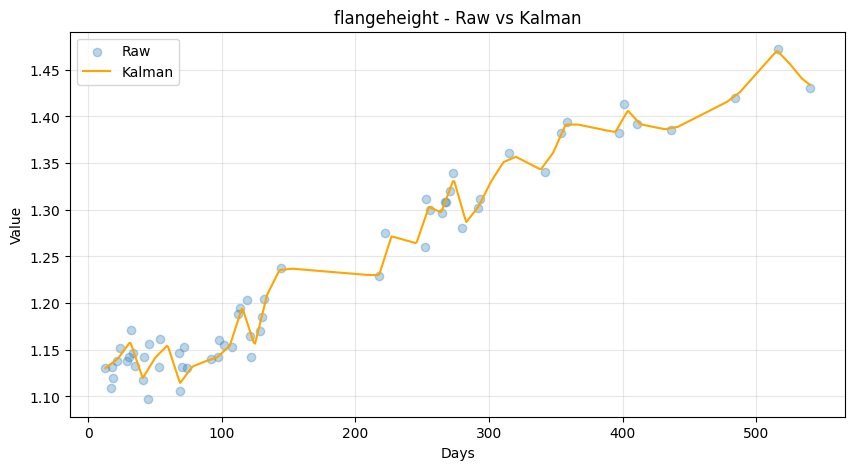

In [26]:
import matplotlib.pyplot as plt
temp = full_wpd[(full_wpd['equipmentnumber'] == 1) & (full_wpd['axle'] == 1) & (full_wpd['side'] == 'L')]['applieddate'].unique()
temp = full_wpd[(full_wpd['equipmentnumber'] == 1) & (full_wpd['axle'] == 1) & (full_wpd['side'] == 'L') & (full_wpd['applieddate'] == temp[1])]
# make sure we have days (if not already in full_wpd)
if "days" not in temp.columns:
    temp["days"] = (temp["traindate"] - temp["traindate"].min()).dt.days

signal = "kalman"
# find all features that have a lowpass
features = [c.replace(f"_{signal}", "") for c in temp.columns if c.endswith(f"_{signal}")]

for feat in features:
    raw_col   = f"{feat}"
    signal_col    = f"{feat}_{signal}"

    if raw_col not in temp or signal_col not in temp:
        continue

    plt.figure(figsize=(10, 5))
    plt.scatter(temp["days"], temp[raw_col], label="Raw", alpha=0.3)
    plt.plot(temp["days"], temp[signal_col], color='orange', label=signal.capitalize())

    plt.title(f"{feat} - Raw vs {signal.capitalize()}")
    plt.xlabel("Days")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    break
